In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image
import os

This imports the Image module from the PIL library. PIL (Python Imaging Library) is a popular library for image processing in Python, providing various functionalities for manipulating and working with images. This imports the os module, which provides a way to interact with the operating system. It allows you to perform various operations related to file and directory manipulation, such as creating, deleting, or listing files and directories.

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

The models module contains various pre-defined neural network architectures, such as Sequential, Functional, or Model subclassing, which you can use to build your models. The layers module provides a wide range of pre-defined layers, such as Dense, Conv2D, MaxPooling2D, and others, that can be used to construct the different layers of a neural network model.

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/ML Project/segmented_images",
    shuffle=True,
    image_size = (512,512),
    batch_size = 16
)

Found 217 files belonging to 3 classes.


Create a dataset from a directory of images; The number of images to be included in each batch of the dataset

In [ ]:
class_names = dataset.class_names
class_names

['Bacterial', 'Fungal', 'Healthy']

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True,shuffle_size=240):
    ds_size = len(ds)
    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=42)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size).take(test_size)

    return train_ds, val_ds, test_ds

"get_dataset_partitions_tf()" function is a utility function that helps in splitting a dataset into training, validation, and test sets. The dataset is shuffled using the specified shuffle_size and a fixed random seed of 42. Finally, the function returns the train_ds, val_ds, and test_ds datasets.


In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

11

In [ ]:
len(val_ds)

1

In [ ]:
len(test_ds)

1

The cache() function caches the elements of the training dataset in memory or on disk. Caching the dataset can improve performance by avoiding unnecessary data loading and preprocessing during each epoch of training. It shuffles the examples using a buffer size of 1000. It prefetches a number of elements from the dataset, allowing the model to train on one batch while the next batch is being prepared. The buffer_size=tf.data.AUTOTUNE argument dynamically determines an appropriate buffer size based on available system resources. It minimizes I/O and preprocessing bottlenecks, ensuring a smooth and efficient training process.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
resize_and_rescale = tf.keras.Sequential ([
    layers.experimental.preprocessing.Resizing(512,512),
    layers.experimental.preprocessing.Rescaling(1.0/512)
    ])

It divides the pixel values by 512, which effectively scales the pixel values between 0 and 1. Rescaling is a common preprocessing step to normalize the input data.

In [ ]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(8, (3,3), activation='relu', input_shape=(512, 512, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(8, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(8, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(8, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(3, activation='softmax')
])
model.build(input_shape=(16, 512, 512, 3))

This defines a CNN model using the Sequential API. It uses the ReLU activation function to introduce non-linearity. It indicating a batch size of 16 and image dimensions of 512x512 with 3 color channels (RGB). 

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Used to compile the CNN model. The loss function measures the discrepancy between the predicted outputs of the model and the true labels. In this case, SparseCategoricalCrossentropy is used, which is suitable for multi-class classification problems where the labels are integers. The from_logits=False argument indicates that the model's output is already a probability distribution (due to the softmax activation in the last layer) and does not need to be converted from logits. Accuracy metric is used, which computes the fraction of correctly classified samples.

In [ ]:
import numpy as np

k = 5 
accuracies = []

for fold in range(k):
    print(f"Training fold {fold+1}/{k}")
    
    train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
    train_images, train_labels = next(iter(train_ds))
    validation_images, validation_labels = next(iter(val_ds))
    test_images, test_labels = next(iter(test_ds))

    history = model.fit(
        train_images,
        train_labels,
        epochs=20,
        batch_size=16,
        verbose=1,
        validation_data=(validation_images, validation_labels)
    )

    scores = model.evaluate(test_images, test_labels)
    accuracies.append(scores[1])

# Calculate the mean accuracy and standard deviation
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation:", std_accuracy)

Training fold 1/5
Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 1.1007 - accuracy: 0.3750 - val_loss: 1.0968 - val_accuracy: 0.2500
Epoch 2/20
1/1 [==============================] - 0s 125ms/step - loss: 1.0883 - accuracy: 0.3750 - val_loss: 1.0942 - val_accuracy: 0.1875
Epoch 3/20
1/1 [==============================] - 0s 136ms/step - loss: 1.0568 - accuracy: 0.4375 - val_loss: 1.0946 - val_accuracy: 0.1875
Epoch 4/20
1/1 [==============================] - 0s 126ms/step - loss: 1.0187 - accuracy: 0.4375 - val_loss: 1.1060 - val_accuracy: 0.1875
Epoch 5/20
1/1 [==============================] - 0s 143ms/step - loss: 1.0035 - accuracy: 0.3750 - val_loss: 1.1358 - val_accuracy: 0.1875
Epoch 6/20
1/1 [==============================] - 0s 136ms/step - loss: 0.9467 - accuracy: 0.3750 - val_loss: 1.1816 - val_accuracy: 0.1875
Epoch 7/20
1/1 [==============================] - 0s 131ms/step - loss: 0.9499 - accuracy: 0.3750 - val_loss: 1.2276 - val_accuracy: 0.1875
Epoch

It used to train the CNN model using the fit method. The number of epochs (iterations over the entire training dataset) for which the model will be trained. Each epoch consists of multiple iterations (steps) where the model updates its weights based on the gradients computed during the forward and backward passes. A value of 1 means it will print progress updates for each epoch. This is the validation dataset, which is used to evaluate the model's performance after each epoch. The model will not be trained on the validation data but will use it to compute metrics such as loss and accuracy during training.

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 sequential_6 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 510, 510, 8)       224       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 255, 255, 8)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 253, 253, 8)       584       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 126, 126, 8)      0         
 2D)                                                  

In [ ]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 3s 3s/step - loss: 0.4301 - accuracy: 0.8125


It is used to evaluate the trained CNN model on the test dataset. It computes the specified metrics (such as loss and accuracy) to evaluate its performance. The specific evaluation metrics that are computed depend on the metrics specified during model compilation (in this case, 'accuracy').

In [ ]:
scores

[0.43010860681533813, 0.8125]

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

"history" refers to the variable that stores the training history of the model. The "history" object is returned by the fit method when training the model. Represents the recorded metrics during training. You can retrieve the recorded metrics and use them for further analysis or visualization.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

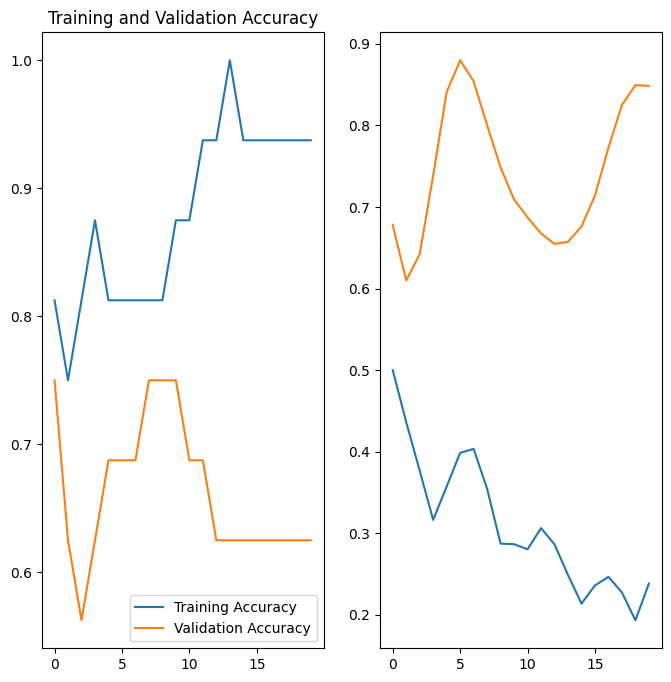

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label='Training Accuracy')
plt.plot(range(20), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Training Loss')
plt.plot(range(20), val_loss, label='Validation Loss')
plt.show()

specified size of 8x8 inches; subplot grid with 1 row and 2 columns and sets the current subplot to the first position; the range of epochs (0 to 9) on the x-axis

Actual Label:  Healthy
1/1 [==============================] - 0s 104ms/step
Predicted Label:  Healthy


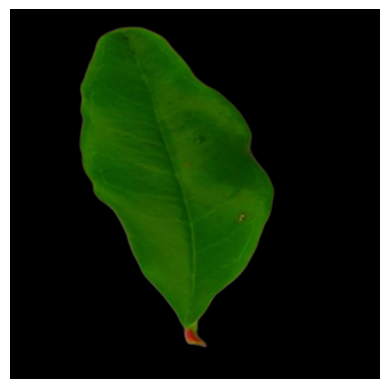

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    plt.imshow(first_image)
    print("Actual Label: ", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("Predicted Label: ", class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

To demonstrate the prediction of your trained CNN model on a batch of test images. Iterates over the test dataset and retrieves a single batch of images and corresponding labels. The take(1) function is used to select only the first batch from the dataset. This retrieves the first image from the batch, converts it to a NumPy array, and casts its data type to "uint8". This prints the actual label of the first image by indexing the class_name list with the corresponding label value. This uses the trained model (model) to predict the labels for the batch of images. This prints the predicted label for the first image in the batch. It uses np.argmax to find the index of the predicted label with the highest probability in the batch_prediction array, and then retrieves the corresponding class name from the class_name list.

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

This adds an extra dimension to the image array at index 0. This is done to match the input shape expected by the model, which typically requires a batch dimension even for a single image. This calculates the confidence or probability of the predicted class. It uses np.max to find the highest probability in the predictions array and multiplies it by 100. 

In [ ]:
len(test_ds)

1

1/1 [==============================] - 0s 23ms/step


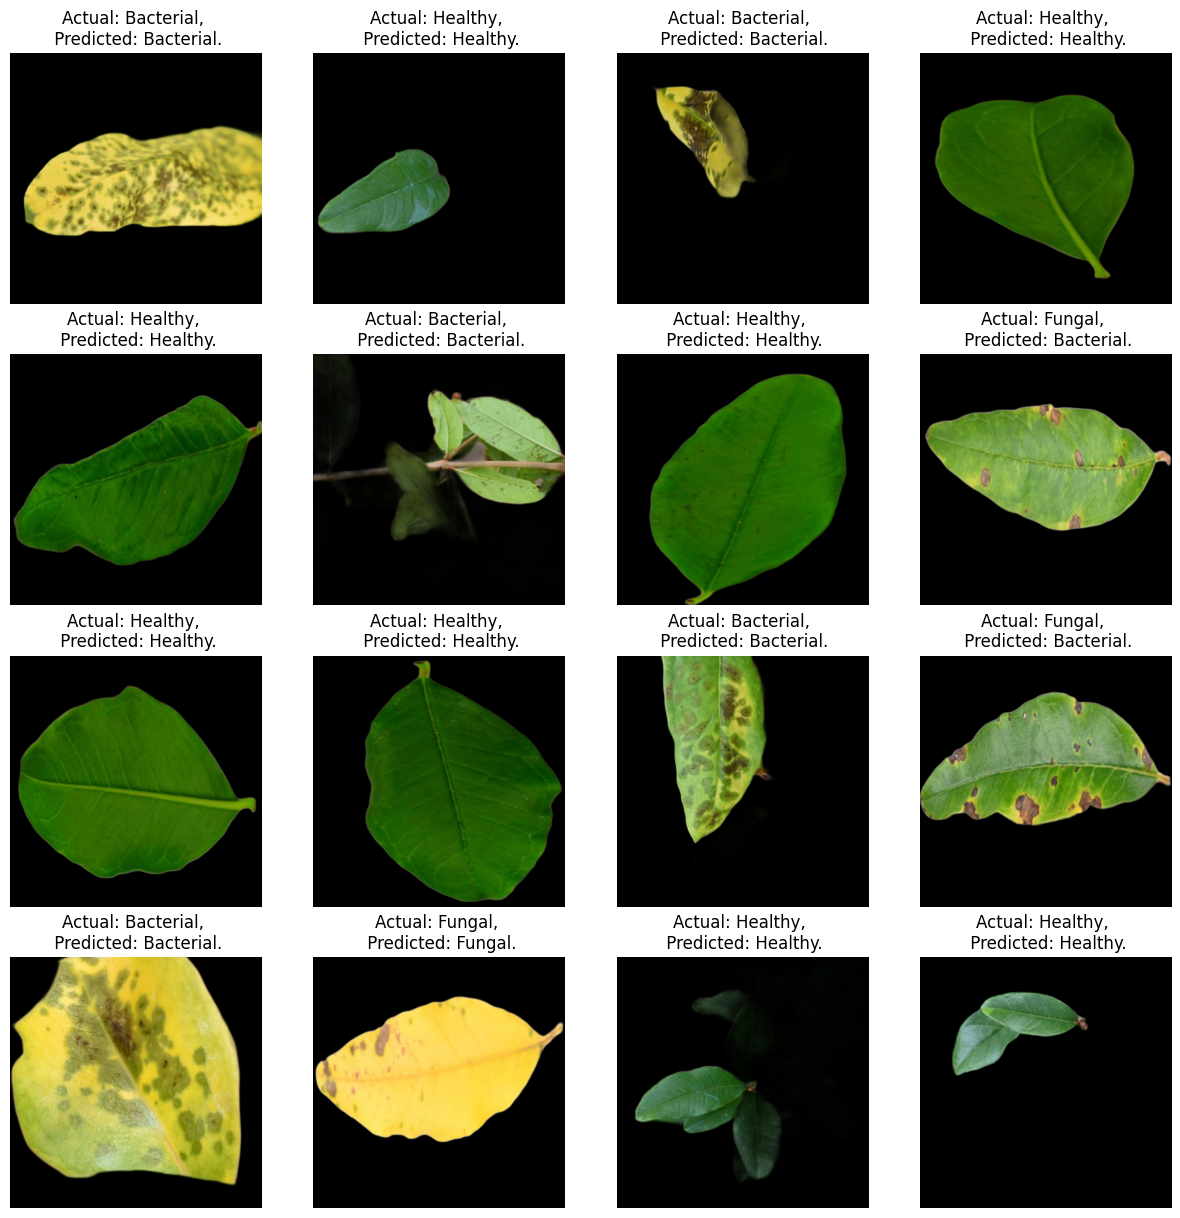

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.")
        plt.axis("off")

This iterates over the test dataset and retrieves a batch of images and labels. The take(1) method is used to retrieve only the first batch. This creates a subplot within the grid at the appropriate position based on the iteration index. The i + 1 is used to ensure the subplot numbering starts from 1. 